In [1]:
import requests
import json
import datetime as dt
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ruptures as rpt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import Adam, Adamax, RMSprop

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)

Using TensorFlow backend.


#### Ethereum Time Series Analysis
1. Introduction
    - Imports:
        - Python: datetime, time, warnings
        - Preprocessing/Viz: numpy, pandas, matplotlib, seaborn, sklearn.preprocessing, ruptures
        - Modeling: statsmodels.tsa.arima_model, tensorflow, keras.models, .layers, .backend
        - Evaluation: statsmodels.tsa.stattools, scipy.stats, sklearn.metrics
    - Description of Research Question/Task
2. Data: TS Only
    - Scrape/APIs/Clean
    - Load/EDA
        - Visualize TS: ADF (Augmented Dickey-Fuller) Unit Root Test
        - Distribution: D'Agostino/Pearson Normality Test
    - Changepoint Analysis
        - PELT (Pruned Exact Linear Time)
    - Feature Engineering: changepoint dummies
3. Modeling/Forecasting
    - ARIMA
        - Stationarity: ADF
        - AR/MA (Auto Regressive/Moving Average): ACF/PACF (Auto/Partial Auto Correlation Functions)
        - Modeling: AIC/BIC (Akaike/Bayesian Information Critera), RMSE (Root Mean Squared Error)
        - Forecasting: Moving window, RMSE
    - Neural Networks
        - MLP ANN (Multi Layer Perceptron Artificial Neural Network): simple, deep, RMSE
        - LSTM RNN (Long Short-Term Memory Recurrent Neural Network): RMSE
    - Visualize/Summarize Results
5. Data: Exogenous Variables
    - Scrape/APIs/Clean
    - Granger Causality
    - Feature Engineering: Collinearity, PCA (Principle Component Analysis), UMAP(?) (Uniform Manifold Approximation and Projection)
6. Modeling/Forecasting
    - ARIMA(X)
    - Neural Networks
        - MLP ANN
        - LSTM RNN
    - Visualize/Summarize Results
7. Overall Summary & Conclusions
8. Deployment

# 1. Introduction

# 2. Data

## 2.1 Data Access & Preprocessing
- Functions to make API calls
- Get desired eth & exogenous variable data (for use in second part of analysis)
- Clean/combine into single df to draw from throughout analysis

In [2]:
def cryptocompare_data(symbol,
                       comparison_symbol='USD',
                       all_data=True,
                       rows=1,
                       aggregate=1,
                       write_to=False):
    
    # symbol = symbol of desired coin
    # comparison symbol = symbol for currency to price with
    # to subset data, set all_data to false, then specificy with rows parameter
    # write_to = write dataframe to supported filetype: csv, json, pkl
    
    # api call
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(),
                    comparison_symbol.upper(),
                    rows,
                    aggregate)
    
    if all_data:
        url += '&allData=true'
    
    # store in dataframe
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['date'] = [dt.datetime.fromtimestamp(d) for d in df.time]
    df['date'] = df.date.dt.date
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.drop('time', axis=1, inplace=True)
    df = df[['date', 'open', 'high', 'low', 'close', 'volumefrom', 'volumeto']]
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # write to file option
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = symbol.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df
    
def fred_data(series_id,
              api_key,
              file_type='json',
              frequency='d',
              raw=False,
              write_to=False):
    
    # series_id = string, symbol from fred
    # filetype options: xml, json, txt, xls
    # frequency options: d = daily, w = weekly, bw = biweekly
    # m = monthly, q = quarterly, sa = semiannual, a = annual
    # raw=True will skip the preprocessing and return the raw data
    # write_to=write dataframe to supported filetype: csv, json, pkl
    
    url = 'https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type={}&frequency={}'\
                  .format(series_id,
                          api_key,
                          file_type,
                          frequency)
    
    response = requests.get(url)
    data = response.json()['observations']
    df = pd.DataFrame(data)
    
    if raw is False:
        df.drop(['realtime_end', 'realtime_start'], axis=1, inplace=True)
        df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
        df.rename(columns={'value':series_id.lower()}, inplace=True)
        
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = series_id.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df

def write_df(df, write_to, filename):
    if write_to == 'csv':
        df.to_csv('{}'.format(filename), index=False)
    elif write_to == 'pkl':
        df.to_pickle('{}'.format(filename))
    elif write_to == 'json':
        df.to_json('{}'.format(filename), orient='split')
    else:
        print('function does not support writing to {}'.format(write_to))
        print('format filetype as shown (string in all lower case)')
        print('supported filetypes: csv, json, pkl')
        
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [3]:
# get coin data
coins = ['ETH', 'BTC', 'XRP', 'EOS', 'LTC', 'XLM', 'XMR']

# create empty df for each coin
coins_d = {coin.lower(): pd.DataFrame() for coin in coins}

# populate coin dfs with respective coin data
for key, df in coins_d.items():
    coins_d[key] = cryptocompare_data(symbol=key)

# add coin names to columns & preview dfs
for key, df in coins_d.items():
    cols_orig = list(coins_d[key].columns)[1:]
    cols_new = ['date']
    for col in cols_orig:
        cols_new.append('{}_{}'.format(key, col))
    coins_d[key].columns = cols_new
    coins_d[key].set_index('date', inplace=True, drop=True)
    #display(coins_d[key].head(1))
    
# combine to single df
coins_df = pd.concat([df for key, df in coins_d.items()], axis=1)
display(coins_df.head(1))

# convert keys:values to variables = assignments
#locals().update(coins_d)

,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc_open,btc_high,btc_low,btc_close,...,xlm_low,xlm_close,xlm_volumefrom,xlm_volumeto,xmr_open,xmr_high,xmr_low,xmr_close,xmr_volumefrom,xmr_volumeto
date,,,,,,,,,,,,,,,,,,,,,
2010-07-16,NaN,NaN,NaN,NaN,NaN,NaN,0.04951,0.04951,0.04951,0.04951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# get fred data
fred_apikey = get_file_contents('fred_apikey')

indices = {
    'VIXCLS':'d', # cboe volatility index
    'TWEXB':'w', # trade weighted usd index
    'EFFR':'d' # effective federal funds rate
    }

# create empty df for each index
indices_d = {index: pd.DataFrame() for index in indices}

# populate dfs with index data
for key in set(indices.keys()) and set(indices_d.keys()):
    indices_d[key] = fred_data(series_id=key,
                               api_key=fred_apikey,
                               frequency = indices[key])
    indices_d[key].set_index('date', inplace=True, drop=True)

# lowercase dict keys, preview dfs
indices_d =  {key.lower(): value for key, value in indices_d.items()}

#for key, df in indices_d.items():
#    display(df.head(1))

# combine to single df    
fred_df = pd.concat([df for key, df in indices_d.items()], axis=1)
display(fred_df.head(1))

# convert to variables = assignments
#locals().update(indices_d)

,vixcls,twexb,effr
date,,,
1990-01-02,17.24,NaN,NaN


In [5]:
# combine data into single df
df_alldata = pd.concat([coins_df, fred_df], axis=1)

# replace '.' with nan so ffill will catch everything
# '.' denotes a holiday
df_alldata.replace('.', np.nan, inplace=True)

# ffill values for weekends skipped by traditional indices
df_alldata.ffill(inplace=True)

# start dataframe at beginning of ethereum
df = df_alldata[df_alldata.eth_close.isnull().sum():]
display(df.head(3))

# check missingness
for col in df.columns:
    if df['{}'.format(col)].isnull().any() == True:
        print(col)

,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc_open,btc_high,btc_low,btc_close,...,xlm_volumeto,xmr_open,xmr_high,xmr_low,xmr_close,xmr_volumefrom,xmr_volumeto,vixcls,twexb,effr
date,,,,,,,,,,,,,,,,,,,,,
2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79,278.00,279.60,274.28,277.89,...,NaN,0.64,0.75,0.6400,0.75,0.021410,0.016060,13.77,118.1833,0.14
2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16,277.89,278.92,257.42,258.60,...,NaN,0.75,0.75,0.4727,0.75,0.001185,0.000632,13.39,118.1833,0.14
2015-08-08,1.2000,1.2,1.2000,1.2,0.00,0.00,258.60,266.75,258.56,263.87,...,NaN,0.75,0.75,0.6000,0.75,10.150000,6.090000,13.39,118.1833,0.14


eos_open
eos_high
eos_low
eos_close
eos_volumefrom
eos_volumeto
xlm_open
xlm_high
xlm_low
xlm_close
xlm_volumefrom
xlm_volumeto


**Note**: EOS & XLM currencies started after ETH (hence their missing values). Will address this later when dealing with exogenous variables

In [7]:
df.to_json('df.json', orient='split')

## 2.2 Time Series EDA

In [8]:
raw = pd.read_json('df.json', orient='split')
ts = pd.DataFrame(raw.eth_close).copy()
ts.head(3)

,eth_close
2015-08-06,3.0
2015-08-07,1.2
2015-08-08,1.2


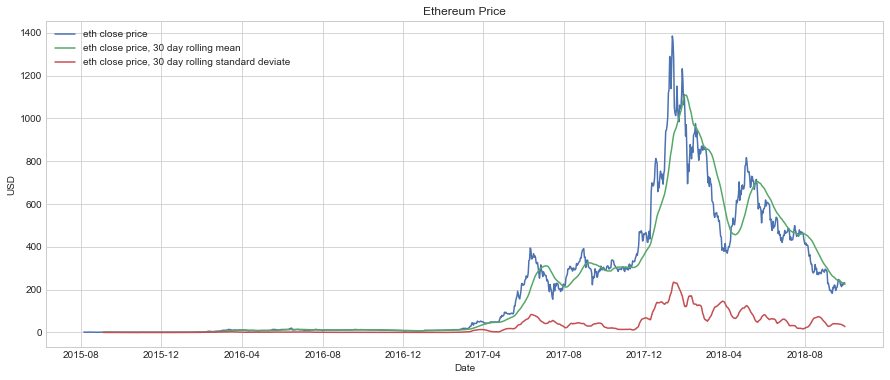

adf: -1.8212108411717751
pval: 0.36998310127040906
critical vals {'1%': -3.4361604996756685, '5%': -2.864105678204421, '10%': -2.568136037454102}


In [9]:
window = 30

plt.figure(figsize=(15,6))
plt.plot(
    ts.index.values,
    ts.eth_close,
    label='eth close price',
    color=colors[0]
)
plt.plot(
    ts.index.values,
    ts.eth_close.rolling(window).mean(),
    label='eth close price, {} day rolling mean'.format(window),
    color=colors[1]
)
plt.plot(
    ts.index.values,
    ts.eth_close.rolling(window).std(),
    label='eth close price, {} day rolling standard deviate'.format(window),
    color=colors[2]
)
plt.title('Ethereum Price')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(ts.eth_close)[0],
    adfuller(ts.eth_close)[1],
    adfuller(ts.eth_close)[4]))

**Interpretation:**
- Data displays trend(s), ADF test confirms non-stationarity
- Data does not appear to have a seasonality component
- Graph indicates presence of structural breaks

**To do:**
- Perform change point analysis
- Get stationary time series

### 2.2.1 Change point analysis

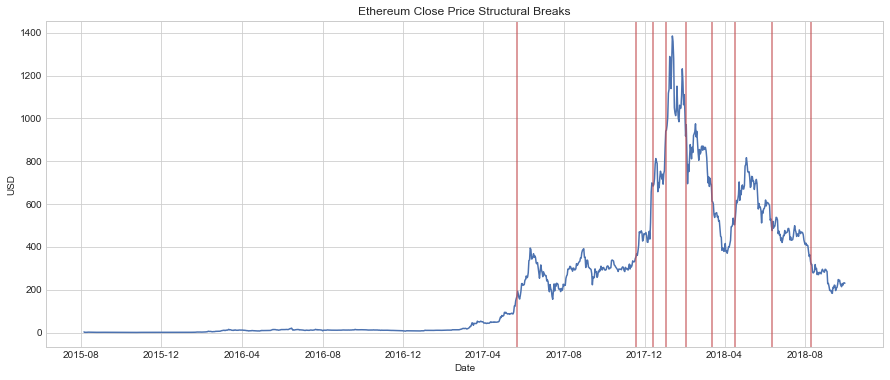

Change points by index: [655, 835, 860, 880, 910, 950, 985, 1040, 1100]


In [10]:
cpts = rpt.Pelt(model='rbf').fit_predict(pd.DataFrame(ts.eth_close), pen=10)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Ethereum Close Price Structural Breaks')
ax.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0]
)
for cpt in cpts[:-1]:
    plt.axvline(
        x=ts.index.values[cpt],
        color=colors[2],
        alpha=.75
    )
ax.set_ylabel('USD')
ax.set_xlabel('Date')

plt.show()

print('Change points by index: {}'.format(cpts[:-1]))

In [11]:
from fbprophet import Prophet

ts_prophet = ts.copy().reset_index()
ts_prophet.columns = (['ds', 'y'])

m = Prophet().fit(ts_prophet)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
deltas = m.params['delta'].mean(0)
cpts_df = pd.DataFrame(
    {'index_locator':m.changepoints.index,
     'cpts':m.changepoints.values,
     'delta':deltas})

# find significant potential changepoints
points = []
for i, row in cpts_df.iterrows():
    if cpts_df.delta[i] >= 0.5:
        points.append(row.index_locator)
    elif cpts_df.delta[i] <= -0.5:
        points.append(row.index_locator)

# create dummies for breaks
for i, point in enumerate(points):
    ts['break_{}'.format(i+1)] = 0
    ts['break_{}'.format(i+1)][point:] = 1

,eth_close,break_1,break_2,break_3,break_4,break_5
2015-08-06,3.00,0,0,0,0,0
2015-08-07,1.20,0,0,0,0,0
2015-08-08,1.20,0,0,0,0,0
2015-08-09,1.20,0,0,0,0,0
2015-08-10,0.99,0,0,0,0,0


### 2.2.2 Stationarity

In [26]:
ts = ts[points[0]:]

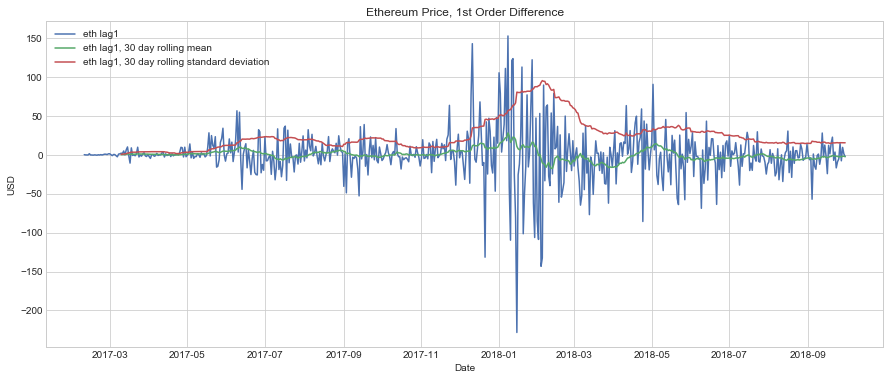

1st order differenced ADF test results

price:
adf -3.7032
pval 0.004069039272794921
critical vals {'1%': -3.441694608475642, '5%': -2.866544718556839, '10%': -2.5694353738653684}

rolling mean:
adf -4.4070
pval 0.00028851239950541203
critical vals {'1%': -3.442295604706236, '5%': -2.866809328264463, '10%': -2.569576376859504}

std dev:
adf -3.0313
pval 0.03207070016606488
critical vals {'1%': -3.442295604706236, '5%': -2.866809328264463, '10%': -2.569576376859504}


In [27]:
ts['lag1'] = diff(ts.eth_close, k_diff=1)
window = 30

plt.figure(figsize=(15,6))
plt.plot(
    ts.index.values[1:],
    ts.lag1[1:],
    label='eth lag1',
    color=colors[0]
)
plt.plot(
    ts.index.values[1:],
    ts.lag1[1:].rolling(window).mean(),
    label='eth lag1, 30 day rolling mean',
    color=colors[1]
)
plt.plot(
    ts.index.values[1:],
    ts.lag1[1:].rolling(window).std(),
    label='eth lag1, 30 day rolling standard deviation',
    color=colors[2]
)
plt.title('Ethereum Price, 1st Order Difference')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

# ADF Tests
adf_lag1 = adfuller(ts.lag1.dropna())
adf_rollingmean = adfuller(ts.lag1.rolling(window).mean().dropna())
adf_rollingstd = adfuller(ts.lag1.rolling(window).std().dropna())

print('1st order differenced ADF test results')
print('\nprice:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_lag1[0], adf_lag1[1], adf_lag1[4]))
print('\nrolling mean:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_rollingmean[0], adf_rollingmean[1], adf_rollingmean[4]))
print('\nstd dev:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_rollingstd[0], adf_rollingstd[1], adf_rollingstd[4]))

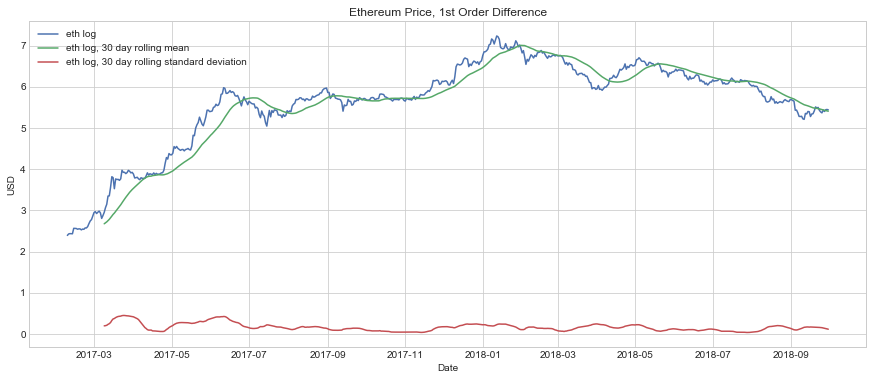

1st order differenced ADF test results

price:
adf -3.8848
pval 0.002149858296862485
critical vals {'1%': -3.441314181564011, '5%': -2.866377195394498, '10%': -2.5693461093196506}

rolling mean:
adf -2.4275
pval 0.13412945749547928
critical vals {'1%': -3.4420185006698127, '5%': -2.8666873299250253, '10%': -2.5695113665058726}

std dev:
adf -4.3369
pval 0.0003831806036198875
critical vals {'1%': -3.4418948967017475, '5%': -2.8666329082535222, '10%': -2.569482366838501}


In [28]:
ts['log'] = np.log(ts.eth_close)
window = 30

plt.figure(figsize=(15,6))
plt.plot(
    ts.index.values,
    ts.log,
    label='eth log',
    color=colors[0]
)
plt.plot(
    ts.index.values,
    ts.log.rolling(window).mean(),
    label='eth log, 30 day rolling mean',
    color=colors[1]
)
plt.plot(
    ts.index.values,
    ts.log.rolling(window).std(),
    label='eth log, 30 day rolling standard deviation',
    color=colors[2]
)
plt.title('Ethereum Price, 1st Order Difference')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

# ADF Tests
adf_log = adfuller(ts.log.dropna())
adf_logrollingmean = adfuller(ts.log.rolling(window).mean().dropna())
adf_logrollingstd = adfuller(ts.log.rolling(window).std().dropna())

print('1st order differenced ADF test results')
print('\nprice:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_log[0], adf_log[1], adf_log[4]))
print('\nrolling mean:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_logrollingmean[0], adf_logrollingmean[1], adf_logrollingmean[4]))
print('\nstd dev:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_logrollingstd[0], adf_logrollingstd[1], adf_logrollingstd[4]))

# 3. Modeling & Forecasting Time Series

## 3.1 ARIMA
### 3.1.1 ACF/PACF

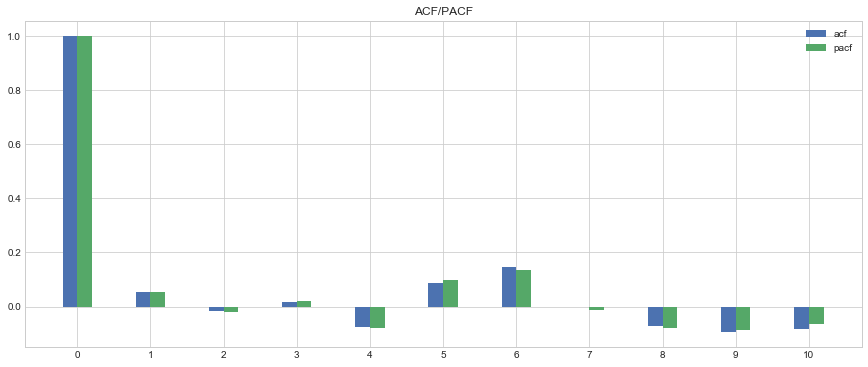

In [31]:
acf_lag1 = acf(ts.lag1.dropna(), nlags=10)
pacf_lag1 = pacf(ts.lag1.dropna(), nlags=10)

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(
    [n-.1 for n in range(len(acf_lag1))],
    acf_lag1,
    label='acf',
    width=.2,
    color=colors[0],
    align='center'
)
ax.bar(
    [n+.1 for n in range(len(acf_lag1))],
    pacf_lag1,
    label='pacf',
    width=.2,
    color=colors[1],
    align='center'
)
ax.legend()
ax.set(title='ACF/PACF',
       xticks= [n for n in range(len(acf_lag1))])

plt.show()

**Interpretation**:
- ACF: perhaps a small MA component
- PACF perhaps a small AR component

### 3.1.2 ARIMA Modeling & Forecasting
- Build the following:
    - ARIMA(0,1,0): d=1, no AR/MA component
    - ARIMA(1,1,0): ar=1, d=1, no MA component
    - ARIMA(0,1,1): d=1, ma=1, no AR component
    - ARIMA(1,1,10: combine in single ARIMA model
- Evaluation:
    - AIC/BIC
    - RMSE

In [ ]:
def rmse(model):
    rmse = np.sqrt(mean_squared_error(ts.lag1.dropna(), model.fittedvalues))
    return rmse

In [ ]:
d1_model = ARIMA(ts.eth_close, order=(0,1,0)).fit()
ar1_model = ARIMA(ts.eth_close, order=(1,1,0)).fit()
ma1_model = ARIMA(ts.eth_close, order=(0,1,1)).fit()
combined_model = ARIMA(ts.eth_close, order=(1,1,1)).fit()

arima_models = {
    'd1_model': d1_model,
    'ar1_model': ar1_model,
    'ma1_model': ma1_model,
    'combined_model': combined_model
}
for name, model in arima_models.items():
    print('{} results'.format(name))
    print('AIC {}\nBIC {}\nRMSE {}\n'.format(model.aic, model.bic, rmse(model)))

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts.lag1.dropna(), label='observed lag1')
plt.plot(d1_model.fittedvalues, label='fitted_vales')
plt.legend()
plt.show()

# 4. Time Series with Exogenous Variables

# 5. Modeling & Forecasting with Exogenous Variables

# 6. Summary & Conclusions